In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "L3J1bi9tZWRpYS9hbGYvZGF0b3MvbWlzcmVwb3NpdG9yaW9zL2RvY2VuY2lhL2FwcmVuZGl6YWplLWF1dG9tYXRpY28tcHJhY3RpY2FzLWp1bGlh"
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
function fibonacci(n::Int)
    a = zeros(Float32, n)
    a[1] = 1
    a[2] = 1
    for i in 3:n
        a[i] = a[i-1] + a[i-2]
    end
    return a
end

fibonacci (generic function with 1 method)

In [3]:
fib = fibonacci(25) 
tamaño = 4
n = 25 - tamaño
# La red esperar una entrada con dimensiones (características, tamaño, lote).
X =  Array{Float32}(undef, 1, tamaño, n)
Y = Array{Float32}(undef, 1, n)  
for i = 1:n
    ventana = fib[i:i+tamaño-1]
    etiqueta = fib[i+tamaño]
    X[1, : , i] .= ventana
    Y[1, i] = etiqueta
end

In [4]:
using Lux, Random

modelo = Chain(
    Recurrence(RNNCell(1 => 1, identity; use_bias = false); return_sequence = false)
)

rng = Random.default_rng()
# Semilla aleatoria para reproducibilidad
Random.seed!(rng, 1234)
ps, st = Lux.setup(rng, modelo)

((layer_1 = (weight_ih = Float32[-1.7194579;;], weight_hh = Float32[1.174417;;]),), (layer_1 = (rng = TaskLocalRNG(),),))

In [5]:
using Statistics
function coste(ps, st, X, Y)
    ŷ, estado = modelo(X, ps, st)          # ŷ: (1, batch)
    return mean((ŷ .- Y).^2)
end

coste(ps, st, X, Y)

6.2632223f9

In [6]:
using Optimisers, Zygote
opt = Optimisers.setup(Optimisers.Adam(0.1f0), ps)

nepocas = 200
costes = []
for epoca in 1:nepocas
    # gradiente de la red con respecto a los parámetros
    gs = first(Zygote.gradient(p -> coste(p, st, X, Y), ps))
    opt, ps = Optimisers.update(opt, ps, gs) 
    push!(costes, coste(ps, st, X, Y))
    println("Época $epoca | coste = ", costes[end])
end

Época 1 | coste = 5.0130447e9


Época 2 | coste = 4.046983e9
Época 3 | coste = 3.3034327e9
Época 4 | coste = 2.7312077e9
Época 5 | coste = 2.2893059e9
Época 6 | coste = 1.94581e9
Época 7 | coste = 1.6764061e9
Época 8 | coste = 1.4628404e9
Época 9 | coste = 1.2915259e9
Época 10 | coste = 1.1523862e9
Época 11 | coste = 1.0379493e9
Época 12 | coste = 9.4265696e8
Época 13 | coste = 8.623539e8
Época 14 | coste = 7.9391226e8
Época 15 | coste = 7.349589e8
Época 16 | coste = 6.836777e8
Época 17 | coste = 6.386652e8
Época 18 | coste = 5.9882643e8
Época 19 | coste = 5.632986e8
Época 20 | coste = 5.313949e8
Época 21 | coste = 5.0256346e8
Época 22 | coste = 4.7635606e8
Época 23 | coste = 4.5240582e8
Época 24 | coste = 4.3040934e8
Época 25 | coste = 4.101142e8
Época 26 | coste = 3.913082e8
Época 27 | coste = 3.7381197e8
Época 28 | coste = 3.5747312e8
Época 29 | coste = 3.4216106e8
Época 30 | coste = 3.277637e8
Época 31 | coste = 3.141841e8
Época 32 | coste = 3.0133814e8
Época 33 | coste = 2.891527e8
Época 34 | coste = 2.77564e8


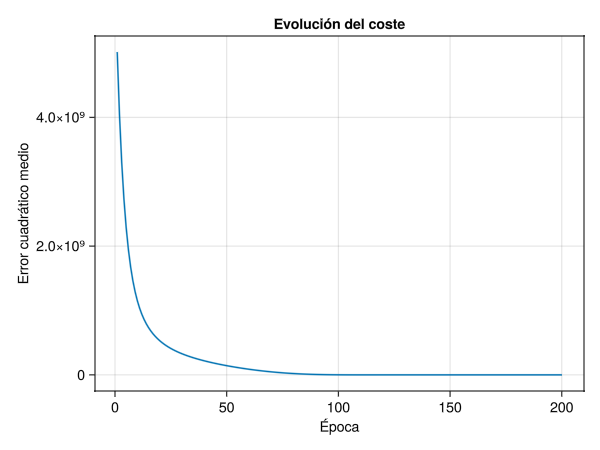

In [7]:
using GLMakie
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Época", ylabel = "Error cuadrático medio", title = "Evolución del coste")
lines!(ax, costes)
fig

In [8]:
fib = fibonacci(30)
X_test = reshape(fib[end-tamaño : end-1], 1, tamaño, 1) 

y_test, _ = modelo(X_test, ps, st)
println("Predicción del término 30: ",  y_test[1, 1])
println("Término 30 de la sucesión de Fibonacci: ", fib[end])

Predicción del término 30: 831997.2
Término 30 de la sucesión de Fibonacci: 832040.0


In [9]:
println("Pesos de la entrada de la red neuronal:", ps.layer_1.weight_ih)
println("Pesos del estado de la red neuronal:", ps.layer_1.weight_hh)

Pesos de la entrada de la red neuronal:Float32[1.662782;;]
Pesos del estado de la red neuronal:Float32[-0.04483252;;]


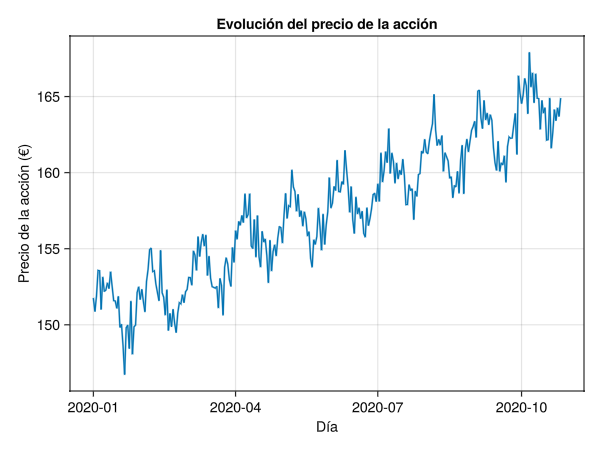

In [10]:
using CSV, DataFrames, GLMakie

# Cargamos el conjunto de datos en un data frame
df = CSV.read("datos/stock.csv", DataFrame)

# Creamos el gráfico de la evolución
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Día", ylabel = "Precio de la acción (€)", title = "Evolución del precio de la acción")

lines!(ax, df.dia, df.precio)
fig

In [11]:
using Statistics

# Simple normalization (z-score)
μ = mean(df.precio)
σ = std(df.precio)
serie = (df.precio .- μ) ./ σ     

300-element Vector{Float64}:
 -1.2770239698472932
 -1.4749432268197025
 -1.2481144154580652
 -0.8745140202741842
 -0.8789616440263692
 -1.4460336724304748
 -0.9679141190701513
 -1.1814000591752272
 -1.1591619404142832
 -1.054642782237841
 -1.1391476335294317
 -0.8923045152829369
 -1.1035666435119202
  ⋮
  1.4249074596075517
  1.5049646871469575
  1.031292757538819
  1.0379641931671029
  1.6472886472170039
  0.9112069162297167
  1.1469309750957366
  1.4782789446338223
  1.3137168658028255
  1.5027408752708586
  1.3759835983334725
  1.6450648353409114

In [12]:
function crear_secuencias(serie, tamaño)
    # Número de ventanas
    n = length(serie) - tamaño  

    # X: (características=1, tamaño=seq_len, lotes=n)
    X = Array{Float32}(undef, 1, tamaño, n)
    # Y: (etiquetas=1, lotes=n)
    Y = Array{Float32}(undef, 1, n)

    for i in 1:n
        ventana = serie[i : i + tamaño - 1]
        etiqueta = serie[i + tamaño]
        X[1, :, i] .= ventana
        Y[1, i] = etiqueta
    end

    return X, Y
end

X, Y = crear_secuencias(serie, 50)

(Float32[-1.2770239 -1.4749433 … -1.7551435 -1.501629;;; -1.4749433 -1.2481145 … -1.501629 -1.6973244;;; -1.2481145 -0.87451404 … -1.6973244 -1.4393623;;; … ;;; 1.7607031 1.3515216 … 1.478279 1.3137169;;; 1.3515216 1.1980786 … 1.3137169 1.5027409;;; 1.1980786 1.6117077 … 1.5027409 1.3759836], Float32[-1.6973244 -1.4393623 … 1.3759836 1.6450648])

In [13]:
Xentrenamiento, Yentrenamiento = X[:, :, 1:200], Y[:, 1:200]
Xtest, Ytest = X[:, :, 201:end], Y[:, 201:end]

(Float32[0.08839652 0.09062033 … 1.3515216 1.1980786;;; 0.09062033 0.3797159 … 1.1980786 1.6117077;;; 0.3797159 0.29298723 … 1.6117077 1.3248359;;; … ;;; 1.7607031 1.3515216 … 1.478279 1.3137169;;; 1.3515216 1.1980786 … 1.3137169 1.5027409;;; 1.1980786 1.6117077 … 1.5027409 1.3759836], Float32[1.6117077 1.3248359 … 1.3759836 1.6450648])

In [14]:
using Lux, Random
modelo = Chain(
    Recurrence(RNNCell(1 => 128); return_sequence = false),
    Dense(128 => 1)
)

rng = Random.default_rng()
# Semilla aletoria para reproducibilidad
Random.seed!(rng, 1234)
ps, st = Lux.setup(rng, modelo)

((layer_1 = (weight_ih = Float32[-0.15198004; 0.10380478; … ; -0.1798741; 0.17066787;;], weight_hh = Float32[-0.07106407 -0.23444848 … -0.29108235 -0.39900473; -0.30030742 -0.065740235 … -0.17046462 -0.23983301; … ; -0.4757619 -0.1054001 … 0.019292383 0.010755149; -0.29641476 -0.082111314 … -0.18774438 -0.22454983], bias_ih = Float32[-0.104035094, -0.37915617, -0.34997502, 0.037953205, -0.21878697, -0.027012689, 0.12676267, 0.050827876, -0.038071405, -0.16504027  …  -0.05652456, 0.06991073, -0.11320838, -0.1762896, 0.053918738, -0.016492352, 0.16167223, -0.3439384, -0.029786063, 0.055757068], bias_hh = Float32[-0.005938923, -0.19251667, 0.12181364, -0.10141703, -0.03740396, 0.01450252, 0.14868438, -0.068561785, -0.25887147, -0.079485  …  0.03813372, -0.077213734, 0.042101383, -0.262799, -0.14517261, -0.21872558, -0.17464997, -0.2874405, 0.17330046, 0.08227109]), layer_2 = (weight = Float32[0.061503585 -0.112972215 … 0.04941277 -0.11658063], bias = Float32[-0.03986097])), (layer_1 = (rn

In [15]:
using Statistics
function coste(ps, st, X, Y)
    ŷ, estado = modelo(X, ps, st)
    return mean((ŷ .- Y).^2)
end

coste(ps, st, X, Y)

4.6247425f0

In [16]:
using Optimisers, Zygote
opt = Optimisers.setup(Optimisers.Adam(0.01f0), ps)

nepocas = 100
costes = []
for epoca in 1:nepocas
    # gradiente de la red con respecto a los parámetros
    gs = first(Zygote.gradient(p -> coste(p, st, Xentrenamiento, Yentrenamiento), ps))
    opt, ps = Optimisers.update(opt, ps, gs) 
    push!(costes, coste(ps, st, Xentrenamiento, Yentrenamiento))
    println("Época $epoca | coste = ", costes[end])
end

Época 1 | coste = 0.72036135
Época 2 | coste = 0.9840572
Época 3 | coste = 1.8454853
Época 4 | coste = 1.7243288
Época 5 | coste = 1.083681
Época 6 | coste = 0.6142939
Época 7 | coste = 0.60723513


Época 8 | coste = 0.90706736
Época 9 | coste = 1.1394985
Época 10 | coste = 1.0966282
Época 11 | coste = 0.8563534
Época 12 | coste = 0.62470526
Época 13 | coste = 0.55528945
Época 14 | coste = 

0.653477
Época 15 | coste = 0.79628235
Época 16 | coste = 0.850392
Época 17 | coste = 0.77980876
Época 18 | coste = 0.65145826
Época 19 | coste = 0.56325483
Época 20 | coste = 0.5667127
Época 21 | coste = 0.63546133


Época 22 | coste = 0.69688535
Época 23 | coste = 0.697185
Época 24 | coste = 0.64105463
Época 25 | coste = 0.5774011
Época 26 | coste = 0.55337125
Época 27 | coste = 0.57722783
Época 28 | coste = 0.61719924
Época 29 | coste = 0.6336023


Época 30 | coste = 0.61333483
Época 31 | coste = 0.5765536
Época 32 | coste = 0.5543303
Época 33 | coste = 0.56062293
Época 34 | coste = 0.5827662
Época 35 | coste = 0.59643084
Época 36 | coste = 0.58893365
Época 37 | coste = 0.56872046


Época 38 | coste = 0.5544553
Época 39 | coste = 0.5565618
Época 40 | coste = 0.5689156
Época 41 | coste = 0.5769913
Época 42 | coste = 0.5727536
Época 43 | coste = 0.5612311
Época 44 | coste = 0.55367357
Época 45 | coste = 0.55578166


Época 46 | coste = 0.56302404
Época 47 | coste = 0.56664556
Época 48 | coste = 0.5629858
Época 49 | coste = 0.5563219
Época 50 | coste = 0.55330956
Época 51 | coste = 0.5558559
Época 52 | coste = 0.5599079
Época 53 | coste = 0.5605722


Época 54 | coste = 0.5573408
Época 55 | coste = 0.5539198
Época 56 | coste = 0.55363333
Época 57 | coste = 0.55593824
Época 58 | coste = 0.55762297
Época 59 | coste = 0.5567134
Época 60 | coste = 0.5544255
Época 61 | coste = 0.5533094


Época 62 | coste = 0.5542069
Época 63 | coste = 0.5555869
Época 64 | coste = 0.5556513
Época 65 | coste = 0.55441266
Época 66 | coste = 0.5533822
Época 67 | coste = 0.5535876
Época 68 | coste = 0.55446374
Época 69 | coste = 0.5547713


Época 70 | coste = 0.5541589
Época 71 | coste = 0.55342954
Época 72 | coste = 0.5533956
Época 73 | coste = 0.5539061
Época 74 | coste = 0.5541877
Época 75 | coste = 0.55388343
Época 76 | coste = 0.55341643
Época 77 | coste = 0.5533415


Época 78 | coste = 0.5536385
Época 79 | coste = 0.5538342
Época 80 | coste = 0.5536672
Época 81 | coste = 0.55337983
Época 82 | coste = 0.5533272
Época 83 | coste = 0.55350786
Época 84 | coste = 0.5536256
Época 85 | coste = 0.55351865


Época 86 | coste = 0.5533456
Época 87 | coste = 0.5533247
Época 88 | coste = 0.5534396
Época 89 | coste = 0.55350053
Época 90 | coste = 0.5534234
Época 91 | coste = 0.553323
Época 92 | coste = 0.5533261
Época 93 | coste = 0.5533998


Época 94 | coste = 0.5534233
Época 95 | coste = 0.5533655
Época 96 | coste = 0.553312
Época 97 | coste = 0.55332816
Época 98 | coste = 0.55337304
Época 99 | coste = 0.55337405
Época 100 | coste = 0.55333257


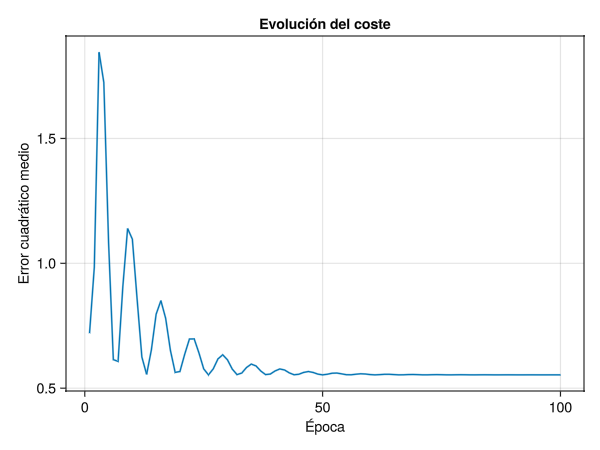

In [17]:
using GLMakie
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Época", ylabel = "Error cuadrático medio", title = "Evolución del coste")
lines!(ax, costes)
fig

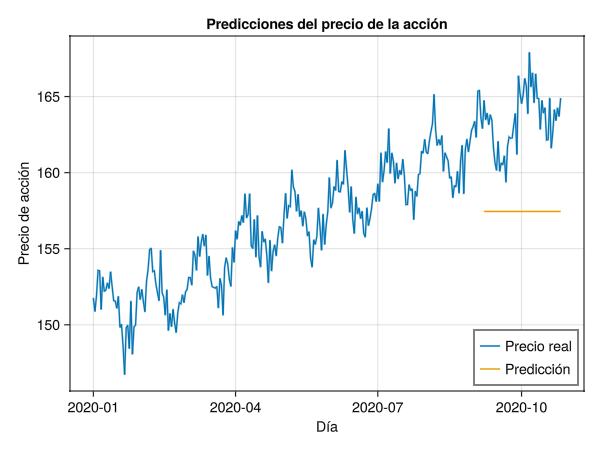

In [18]:
y_test, _ = modelo(Xtest, ps, st)
predicciones = y_test .* σ .+ μ

fig = Figure()
ax = Axis(fig[1,1], xlabel = "Día", ylabel = "Precio de acción", title = "Predicciones del precio de la acción")
lines!(ax, df.dia, df.precio, label = "Precio real")
lines!(ax, df.dia[251:end], vec(predicciones), label = "Predicción")
axislegend(ax, position = :rb)
fig